# SM Limit

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from tqdm import tqdm

import uproot
from uproot_methods.classes.TLorentzVector import TLorentzVectorArray
import pyhf

import os
os.sys.path.append('../code')
from AnalysisUtils import nanoToDf, data2bSigDf
from AnalysisUtils import getExpectedBand #getLambdaWeights
from plotting import sig_bkg_massplanes
from preprocess import read_tsv

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Step 1: Load in the data

Since I'm just trying to get a SM limit here and not validate the rw, I can just load in the singal samples.

*Maybe it would also be fun to use dask here?*

Not yet - I'll look into this later.


**It would be cool if I added functionality to this nb to run on lxplus or slac!!**

In [2]:
mc_fileName   = "/eos/atlas/atlascerngroupdisk/phys-hdbs/diHiggs/bbbb/NNT_FEB20_pflow_bdt/MC/450000_mc16{}/NanoNTuple.root"
data_fileName = "/eos/atlas/atlascerngroupdisk/phys-hdbs/diHiggs/bbbb/NNT_FEB20_pflow_bdt/with_weights/data{}_NN_100_bootstraps.root"

In [3]:
years = [15,16,17,18]

Get the luminosities for the signal normalization (looking at [Sean's repo](https://gitlab.cern.ch/hh4b/hh4b-background-estimation/blob/nn-rw-dev/Resolved/rw_utils.py#L134-137))

In [8]:
L = {
        15: 3.2,
        16: 24.6,
        17: 43.65,
        18: 58.45
    }

In [9]:
sum([l for k,l in L.items()])

129.9

In [ ]:
# smnr = {k: nanoToDf(mc_fileName.format(k),'sig') for k in ['a','d','e']}

In [87]:
smnr = {}
branches = ['m_hh','run_number','kinematic_region','ntag','mc_sf']

for mc, yr in zip(['a','a','d','e'], years):
    
    df = nanoToDf(mc_fileName.format(mc), 'sig', branches)
    
    mask = (df.ntag >= 4)
     
    if (mc == 'a'):
        if (yr == 15):
            mask = mask & (df.run_number < 296939)
        elif (yr == 16):
            mask = mask & (df.run_number > 296939)
        lumi = L[15]+L[16]
    else:
        lumi = L[yr]
        
    df['mc_sf'] *= lumi
    
    smnr[yr] = df[mask]

sig
sig
sig
sig


In [ ]:
# The weights for the nominal training
#f'NN_d24_weight_{k}',f'NN_d24_weight_CRderiv_{k}',

In [59]:
%%time 

data = {}

for k in [15,16,17,18]:
    print(f"Getting 2b sig data{k}")
    
    branches = ['m_hh','run_number','kinematic_region','ntag','mc_sf',
                
                f'NN_d24_weight_bstrap_med_{k}',
                f'NN_d24_weight_CRderiv_bstrap_med_{k}']
    
    data[k] = data2bSigDf(data_fileName.format(k), branches, k)

Getting 2b sig data15
Getting 2b sig data16
Getting 2b sig data17
Getting 2b sig data18
CPU times: user 49.7 s, sys: 9.13 s, total: 58.8 s
Wall time: 18min 29s


Agh, this is taking 20 min??? I probably should try to speed this up (later though).

## Step 1: Stats only limit

I liked the setup I used for the btagging optimization studies - overlaying all the $m_{hh}$ distributions - but now for all of the years!!


In [66]:
edges = np.array([150, 250, 262, 275, 288, 302, 317, 332, 348, 365, 383, 402, 422, 443, 465, 488, 512, 
                  537, 563, 591, 620, 651, 683, 717, 752, 789, 828, 869, 912, 957,1004, 1054, 1106, 1161, 
                  1219, 1279, 1342, 1409, 1479, 1552, 1629, 1710, 1795, 1884, 1978, 2076])
x = 0.5*(edges[:-1]+edges[1:])

In [151]:
text = '$\mathbf{ATLAS}$ Internal\n'
text += 'FEB 2020 prod\n'
text += 'DL1r 77% WP, BDT pairing\n' 
text += 'NN rw median of 100 bootstraps'

In [81]:
yields = pd.DataFrame(0,index=['$s$','$b$','$s/\sqrt{b}$', '$s/b$'],columns=years)

In [146]:
bidx = ['$-2\sigma$','$-\sigma$','exp','$+\sigma$', '$+2\sigma$']
mu_tests = np.linspace(1,150, 150)

stats = pd.DataFrame(0,index=bidx,columns=years)
sys   = pd.DataFrame(0,index=bidx,columns=years)

/afs/cern.ch/user/h/hartman/Work/public/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide
/afs/cern.ch/user/h/hartman/Work/public/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


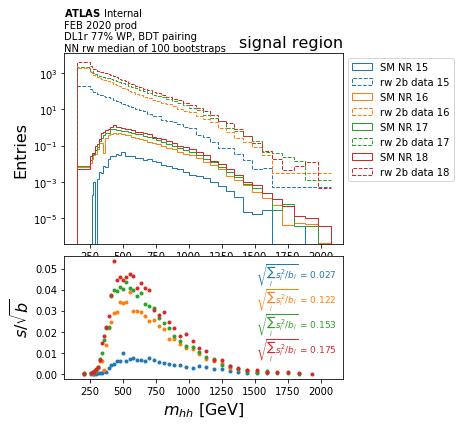

In [155]:
fig = plt.figure(figsize=(5, 6))
gs = gridspec.GridSpec(5,1)
ax1 = fig.add_subplot(gs[:3,0])
ax2 = fig.add_subplot(gs[3:,0],sharex=ax1)

spec = { 'channels': [] }

# Loop through the options (using the bdt pairing)
for yr,color,ytxt in zip(years,['C0','C1','C2','C3'],[.95,.75,.55,.35]):

    # signal
    s,_,_ = ax1.hist(smnr[yr]['m_hh'], edges, color=color,
                     histtype='step', log=True, 
                     label=f"SM NR {yr}",
                     ls='-', weights=smnr[yr]['mc_sf'])

    # background
    b,_,_ = ax1.hist(data[yr]['m_hh'],edges,color=color,
                     histtype='step', log=True, 
                     label=f"rw 2b data {yr}",
                     ls='--',weights=data[yr]['w_2b'])

    # Significance
    ax2.plot(x,s/np.sqrt(b),marker='.',color=color,linewidth=0)

    # Calculate the limit
    sigText = '$\sqrt{\sum_i{s_i^2 / b_i}}$ = '

    ax2.text(.975,ytxt,sigText+'{:.3f}'.format(np.sqrt(np.sum(s[b!=0]**2 / b[b!=0]))),
             ha='right',va='top',fontsize=9,
             transform=ax2.transAxes,color=color)

    # Save the yields
    yields.loc['$s$',yr] = np.sum(s)
    yields.loc['$b$',yr] = np.sum(b)
    yields.loc['$s/\sqrt{b}$',yr] = np.sum(s) / np.sqrt(np.sum(b))
    yields.loc['$s/b$',yr] = np.sum(s) / np.sum(b)

    '''
    It would be great to just run the limit here
    '''
    band = getExpectedBand(s,b,mu_tests)
    stats.loc[bidx,yr] = band
    
    # For the combined stats limit - write out the channel for this year
    chan = {  
            'name': f'{yr}',
            'samples' : [
                {
                    'name': 'signal',
                    'data': list(s),
                    'modifiers': [
                        {'name': 'mu', 'type': 'normfactor', 'data': None}
                    ],
                },
                {
                    'name': 'background',
                    'data': list(b),
                    'modifiers':[],
                },
            ],
        }
    
    spec['channels'].append(chan)
    
# Text per subfig
ax2.set_ylabel('$s / \sqrt{b}$',fontsize=16)

# Make the plot pretty
ax2.set_xlabel('$m_{hh}$ [GeV]',fontsize=16)
ax1.set_ylabel('Entries', fontsize=16)
ax1.set_title('signal region', loc='right',fontsize=16)
ax1.legend(bbox_to_anchor=(1,1))

ax1.text(0,1,text,ha='left',va='bottom',transform=ax1.transAxes)

plt.savefig('figures/m_hh_SR_allYears.pdf',bbox_inches='tight')

plt.show()

In [134]:
# fig = plt.figure(figsize=(5, 6))
# gs = gridspec.GridSpec(5,1)
# ax1 = fig.add_subplot(gs[:3,0])
# ax2 = fig.add_subplot(gs[3:,0],sharex=ax1)

# # background
# b16,_,_ = ax1.hist(data[16]['m_hh'],edges,color='C1',
#                  histtype='step', log=True, 
#                  label=f"rw 2b data 16",
#                  ls='--',weights=data[16]['w_2b'])
# b17,_,_ = ax1.hist(data[17]['m_hh'],edges,color='C2',
#                  histtype='step', log=True, 
#                  label=f"rw 2b data 17",
#                  ls='--',weights=data[17]['w_2b'])

# # Ratio
# ax2.plot(x,b17/b16,marker='.',color='C2',linewidth=0)
    
# # Text per subfig
# ax2.set_ylabel('2017 / 2016',fontsize=16)

    
# # Make the plot pretty
# ax2.set_xlabel('$m_{hh}$ [GeV]',fontsize=16)
# ax1.set_ylabel('Entries', fontsize=16)
# ax1.set_title('signal region', loc='right',fontsize=16)
# ax1.legend(bbox_to_anchor=(1,1))

# ax1.text(0,1,text,ha='left',va='bottom',transform=ax1.transAxes)

# plt.show()

**Thoughts**
- Something is wrong with the orange line rn
- Is 2018 not doing as well as we would have liked?

In [148]:
yields

15            16            17            18
$s$              0.425069      5.919520     10.082191     14.274003
$b$           1217.928032  10049.878411  13405.812784  23045.081630
$s/\sqrt{b}$     0.012180      0.059048      0.087078      0.094028
$s/b$            0.000349      0.000589      0.000752      0.000619

In [153]:
mi = pyhf.Model(spec)

#mus = np.linspace(0,50)
alpha = 0.05

# Get the scan over mu
hypo_tests = [pyhf.utils.hypotest(mu, mi.expected_data([0]), mi,
                                  0.5, [(0,np.max(mu_tests))],
                                  return_expected_set=True,
                                  return_test_statistics=True,
                                  qtilde=True)
              for mu in mu_tests]

cls_exp = [np.array([test[1][i] for test in hypo_tests]).flatten() for i in range(5)]

# Invert the interval
band = [np.interp(alpha, list(reversed(y_vals)), list(reversed(mu_tests)))
        for y_vals in cls_exp]

stats.loc[bidx,'combined'] = band


/afs/cern.ch/user/h/hartman/Work/public/miniconda3/envs/py3/lib/python3.7/site-packages/pyhf/tensor/numpy_backend.py:184: RuntimeWarning: divide by zero encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)
/afs/cern.ch/user/h/hartman/Work/public/miniconda3/envs/py3/lib/python3.7/site-packages/pyhf/tensor/numpy_backend.py:184: RuntimeWarning: invalid value encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)
/afs/cern.ch/user/h/hartman/Work/public/miniconda3/envs/py3/lib/python3.7/site-packages/pyhf/tensor/numpy_backend.py:184: RuntimeWarning: invalid value encountered in multiply
  return n * np.log(lam) - lam - gammaln(n + 1.0)


In [154]:
stats.round(2)

15     16     17     18  combined
$-2\sigma$   39.42   8.72   6.95   6.06      4.00
$-\sigma$    53.44  11.72   9.37   8.16      5.46
exp          75.28  16.33  12.99  11.36      7.55
$+\sigma$   106.87  22.85  18.17  15.84     10.49
$+2\sigma$  146.72  30.87  24.50  21.33     14.05

In [139]:
130/108

1.2037037037037037

In [157]:
11*.8*108/130

7.310769230769232

## Step 2: Limit with systematics 

Could I make impact and pull plots here as well?